In [1]:
pip install -q opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q -U "tensorflow-text==2.9.*"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.11.3 requires tensorflow~=2.11.0, but you have tensorflow 2.9.3 which is incompatible.
tf-models-official 2.11.3 requires tensorflow-text~=2.11.0, but you have tensorflow-text 2.9.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q tf-models-official

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U jax jaxlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
from tqdm import trange
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from sklearn.metrics import f1_score
from tqdm import tqdm
import pickle

## Load data

Using 100K sample size for **bert**.

In [81]:
df_metadata = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df = df_metadata.sample(n=100000, random_state=0)

In [82]:
df_out_of_sample = df_metadata[~df_metadata.isin(df)].dropna()

In [83]:
(len(df_metadata), len(df), len(df_out_of_sample))

(209527, 100000, 109527)

In [84]:
#mapping dict for labels
label_dict = {}
index=0
for l in df.category.unique():
    label_dict[l] = index
    index += 1

In [85]:
df['category'] = df['category'].map(label_dict)
df_out_of_sample['category'] = df_out_of_sample['category'].map(label_dict)

In [86]:
text = df['headline'].values
labels = df['category'].values

In [87]:
df['encoded_cat'] = df['category'].astype('category').cat.codes
data_texts = df["headline"].to_list() # Features (not-tokenized yet)
data_labels = df["category"].to_list() # Lables
oos_labels = df_out_of_sample['category'].to_list()
oos_texts = df_out_of_sample.headline.to_list()

In [88]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)

# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(data_texts, data_labels, test_size=0.01, random_state=0)

In [102]:
def get_train_vali_test(X, y, ratio_train = 0.8, ratio_val = 0.1, ratio_test = 0.1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio_test, random_state=42, shuffle=True)
    ratio_remaining = 1 - ratio_test
    ratio_val_adjusted = ratio_val / ratio_remaining
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=ratio_val_adjusted, random_state=42, shuffle=True)
    return X_train, X_test, X_val, y_train, y_test, y_val

In [106]:
train_texts, test_texts, val_texts, train_labels, test_labels, val_labels = get_train_vali_test(data_texts, data_labels)

In [79]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [80]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

### Logit Model (baseline)

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from sklearn.linear_model import LogisticRegression

In [107]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=None,  # applied preprocessor in Data Cleaning
                        tokenizer=word_tokenize,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True,
                        stop_words= 'english',
                        max_df=0.5,
                        sublinear_tf=True)

In [108]:
X =  tfidf.fit_transform(train_texts)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [109]:
clf = LogisticRegression(max_iter=100000000, C=5).fit(X, train_labels)

In [110]:
X_val = tfidf.transform(val_texts)
X_test = tfidf.transform(test_texts)

In [111]:
f1_score(train_labels, clf.predict(X), average='micro')

0.88205

In [112]:
f1_score(val_labels, clf.predict(X_val), average='micro')

0.5623

In [113]:
f1_score(test_labels, clf.predict(X_test), average='micro')

0.5575

In [97]:
X_oos = tfidf.transform(oos_texts[:20000])

In [98]:
f1_score(oos_labels[:20000], clf.predict(X_oos), average='micro')

0.5767

### Load Pretrained Model (distilbert) 

In [11]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=42)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

### Model Training

In [12]:
history = model.fit(train_dataset.shuffle(100).batch(100), epochs=8, batch_size=100,
          validation_data=val_dataset.shuffle(100).batch(100))

Epoch 1/8
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


990/990 [==============================] - 3735s 4s/step - loss: 1.6891 - accuracy: 0.5499 - val_loss: 1.2567 - val_accuracy: 0.6360
Epoch 2/8
990/990 [==============================] - 3606s 4s/step - loss: 1.1468 - accuracy: 0.6664 - val_loss: 0.9611 - val_accuracy: 0.7161
Epoch 3/8
990/990 [==============================] - 3601s 4s/step - loss: 0.8659 - accuracy: 0.7427 - val_loss: 0.7020 - val_accuracy: 0.7891
Epoch 4/8
990/990 [==============================] - 3615s 4s/step - loss: 0.6359 - accuracy: 0.8078 - val_loss: 0.5100 - val_accuracy: 0.8495
Epoch 5/8
990/990 [==============================] - 3617s 4s/step - loss: 0.4590 - accuracy: 0.8587 - val_loss: 0.3705 - val_accuracy: 0.8952
Epoch 6/8
990/990 [==============================] - 3618s 4s/step - loss: 0.3256 - accuracy: 0.8991 - val_loss: 0.2666 - val_accuracy: 0.9291
Epoch 7/8
990/990 [==============================] - 3645s 4s/step - loss: 0.2333 - accuracy: 0.9268 - val_loss: 0.2241 - val_accuracy: 0.9441
Epoch 8/8

In [24]:
#second training
history_second = model.fit(train_dataset.shuffle(100).batch(100), epochs=2, batch_size=100,
          validation_data=val_dataset.shuffle(100).batch(100)) 

Epoch 1/2
990/990 [==============================] - 3782s 4s/step - loss: 0.1391 - accuracy: 0.9558 - val_loss: 0.1708 - val_accuracy: 0.9645
Epoch 2/2
990/990 [==============================] - 3613s 4s/step - loss: 0.1153 - accuracy: 0.9631 - val_loss: 0.1670 - val_accuracy: 0.9661


In [43]:
his_dict = history.history
history_second_dict = history_second.history

### Save model and training history

In [14]:
#with open("save_model_v3/history.json", "w") as outfile:
    #json.dump(his_dict, outfile)

In [29]:
#with open("save_model_v3/history_second.json", "w") as outfile:
    #json.dump(history_second_dict, outfile)

In [77]:
df_hisory_1 = pd.read_json('save_model_v3/history.json')
df_hisory_2 = pd.read_json('save_model_v3/history_second.json')

df_history = pd.concat([pd_hisory_1, pd_hisory_2]).reset_index(drop=True)

<AxesSubplot: title={'center': 'training history'}, xlabel='epoch', ylabel='accuracy'>

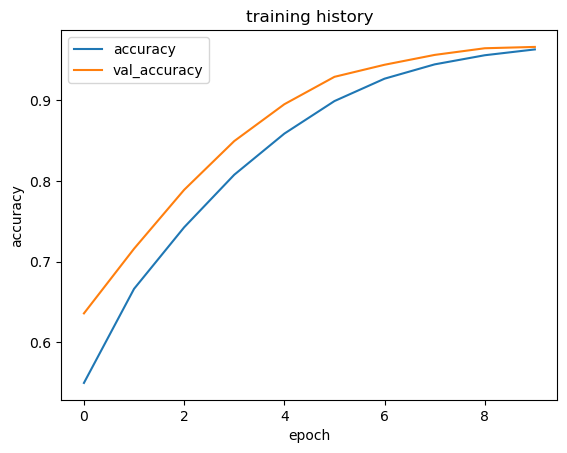

In [71]:
df_history.plot(title='training history', y=['accuracy', 'val_accuracy'], xlabel='epoch', ylabel='accuracy')

<AxesSubplot: title={'center': 'training history'}, xlabel='epoch', ylabel='loss'>

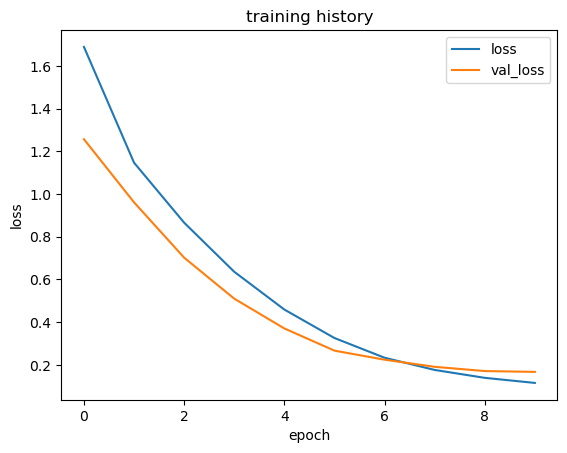

In [72]:
df_history.plot(title='training history', y=['loss', 'val_loss'], xlabel='epoch', ylabel='loss')

In [15]:
#save_directory = "save_model_v3" 
#model.save_pretrained(save_directory)
#tokenizer.save_pretrained(save_directory)

('save_model_v3/tokenizer_config.json',
 'save_model_v3/special_tokens_map.json',
 'save_model_v3/vocab.txt',
 'save_model_v3/added_tokens.json')

In [13]:
load_directory = "save_model_v3" 
loaded_tokenizer = DistilBertTokenizer.from_pretrained(load_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(load_directory)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at save_model_v3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


### Model Evaluation

In [14]:
def make_prediciton(input_text):
    predict_input = loaded_tokenizer.encode(input_text,
                                     truncation=True,
                                     padding=True,
                                     return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    pred_label = [d for d in label_dict if label_dict[d] == prediction_value][0]
    return pred_label

In [15]:
def ev_pred(input_text):
    predict_input = loaded_tokenizer.encode(input_text,
                                     truncation=True,
                                     padding=True,
                                     return_tensors="tf")

    output = loaded_model(predict_input)[0]

    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    return prediction_value

In [16]:
make_prediciton('Look of the Week: Hunter Schafers ethereal Oscars after-party look')

'STYLE & BEAUTY'

In [ ]:
pred = [ev_pred(t) for t in tqdm(test_texts)]

In [208]:
f1_score(test_labels, pred, average='micro')

0.599

In [230]:
pred_oos = [ev_pred(t) for t in tqdm(oos_texts[:20000], position=0, leave=True)]

100%|██████████| 20000/20000 [27:28<00:00, 12.13it/s]


In [232]:
f1_score(oos_labels[:20000], pred_oos, average='micro')

0.5991